In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Зчитаємо дані:

In [2]:
train_data = pd.read_csv('./lab3_data/train.csv')

Попередній перегляд кількох перших рядків набору даних тренування і тестування:

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Зобразимо дані по кожній з колонок спочатку з набору даних тренування:

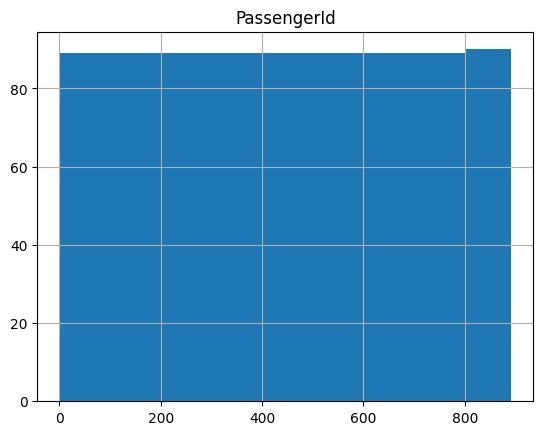

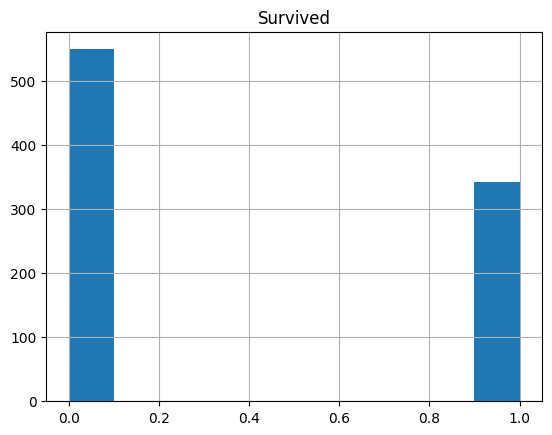

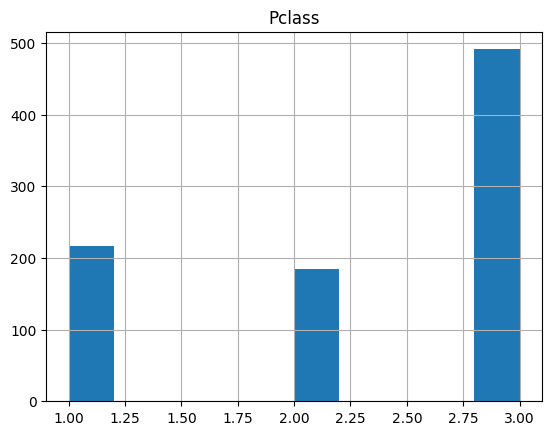

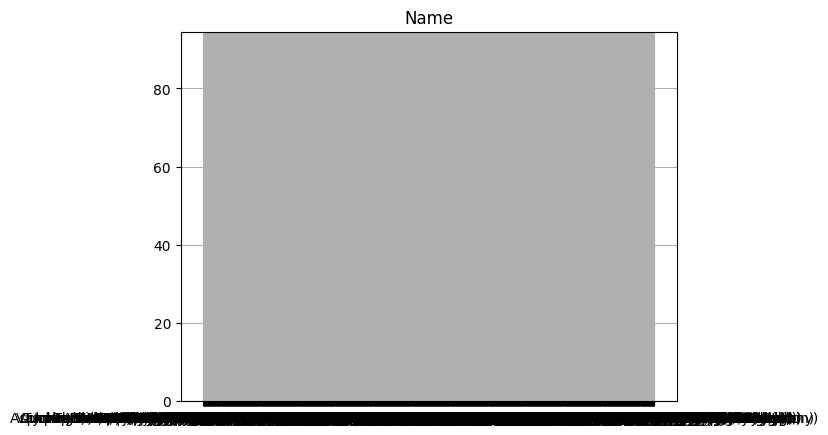

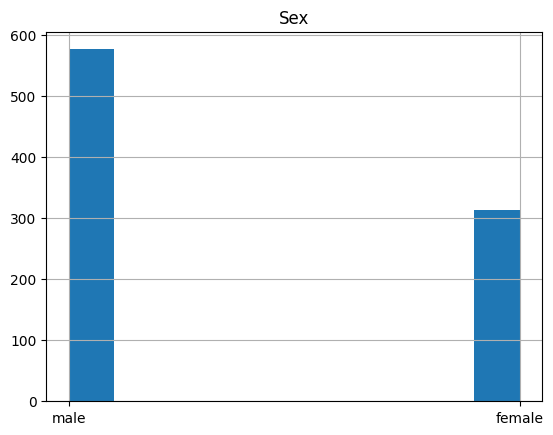

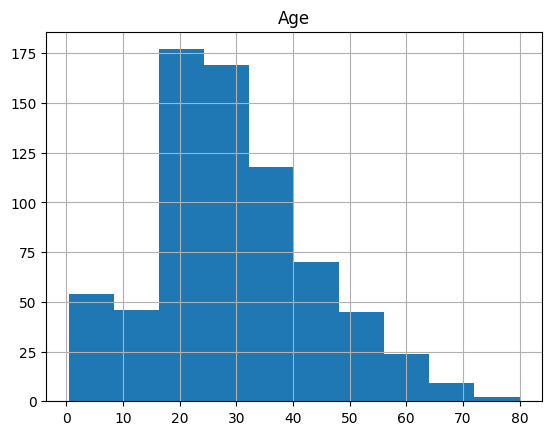

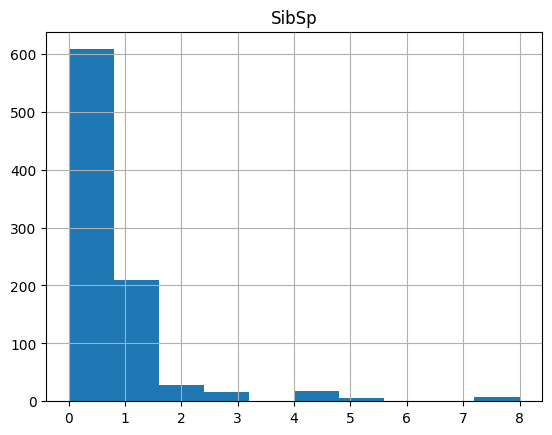

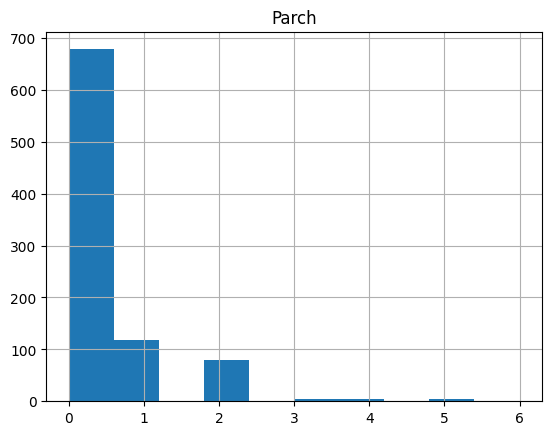

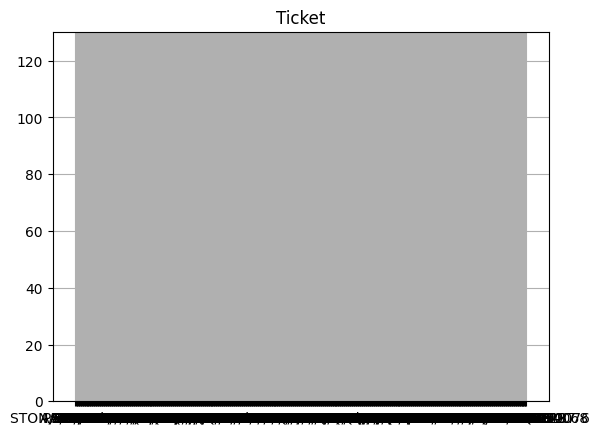

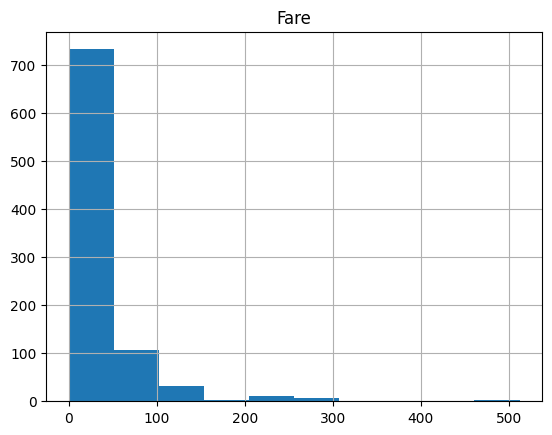

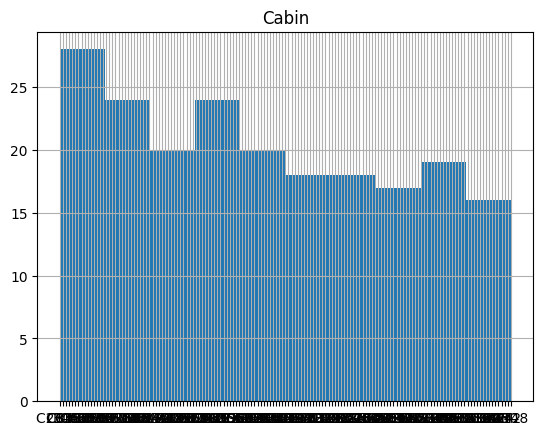

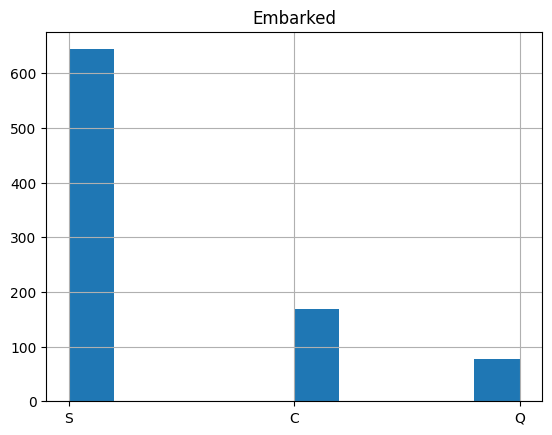

In [4]:
for col in train_data.columns:
    plt.figure()
    train_data[col].hist()
    plt.title(col)
    plt.show()

Подивимось чи є дуплікати

In [5]:
train_data.drop(columns=["PassengerId", "Survived"], axis=1).duplicated().sum()

np.int64(0)

Дублікатів немає

Подивимось на коротку інформацію про збережені дані, а також на кількість ненульових значень в колонках:

In [6]:
print("\tTRAIN DATA:\n")
print(train_data.info(), "\n\n")

	TRAIN DATA:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 




Видно, що є відсутні дані. Заповнимо їх:

In [7]:
train_data.fillna({
    'Age': train_data['Age'].median(), 
    'Embarked': train_data['Embarked'].mode()[0]
    }, inplace=True)

Для зручності в подальшому аналізі, видалимо непотрібні колонки:

In [8]:
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

Тепер закодуємо категоріальні змінні:

In [9]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
train_data['Sex'] = train_data['Sex'].apply(lambda x: 1 if x == 'male' else 0)
train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=False)


Для кластеризації даних використаємо методи k-середніх (k-means) та агломеративну (Agglomerative):

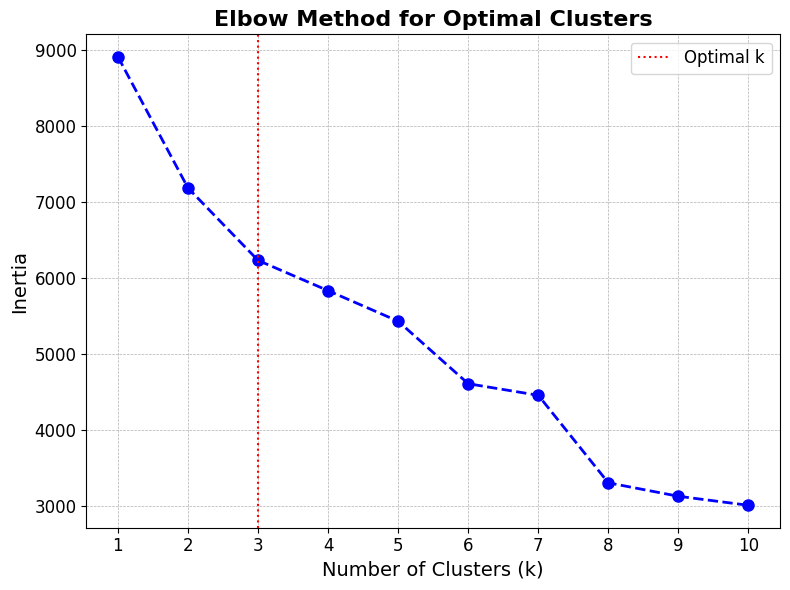

In [10]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(train_data)


inertias_list = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias_list.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertias_list, marker="o", color="blue", linestyle="--", linewidth=2, markersize=8)
plt.title("Elbow Method for Optimal Clusters", fontsize=16, fontweight="bold")
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle="--", linewidth=0.5)
plt.axvline(x=3, color="red", linestyle=":", linewidth=1.5, label="Optimal k")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Видно, що найбільш оптимальною кількістю кластерів є 3, оскільки на цій кількості починає сповільнюватись спадання. Зробимо кластеризацію на наборі тестових даних:

C:\Users\nsimk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


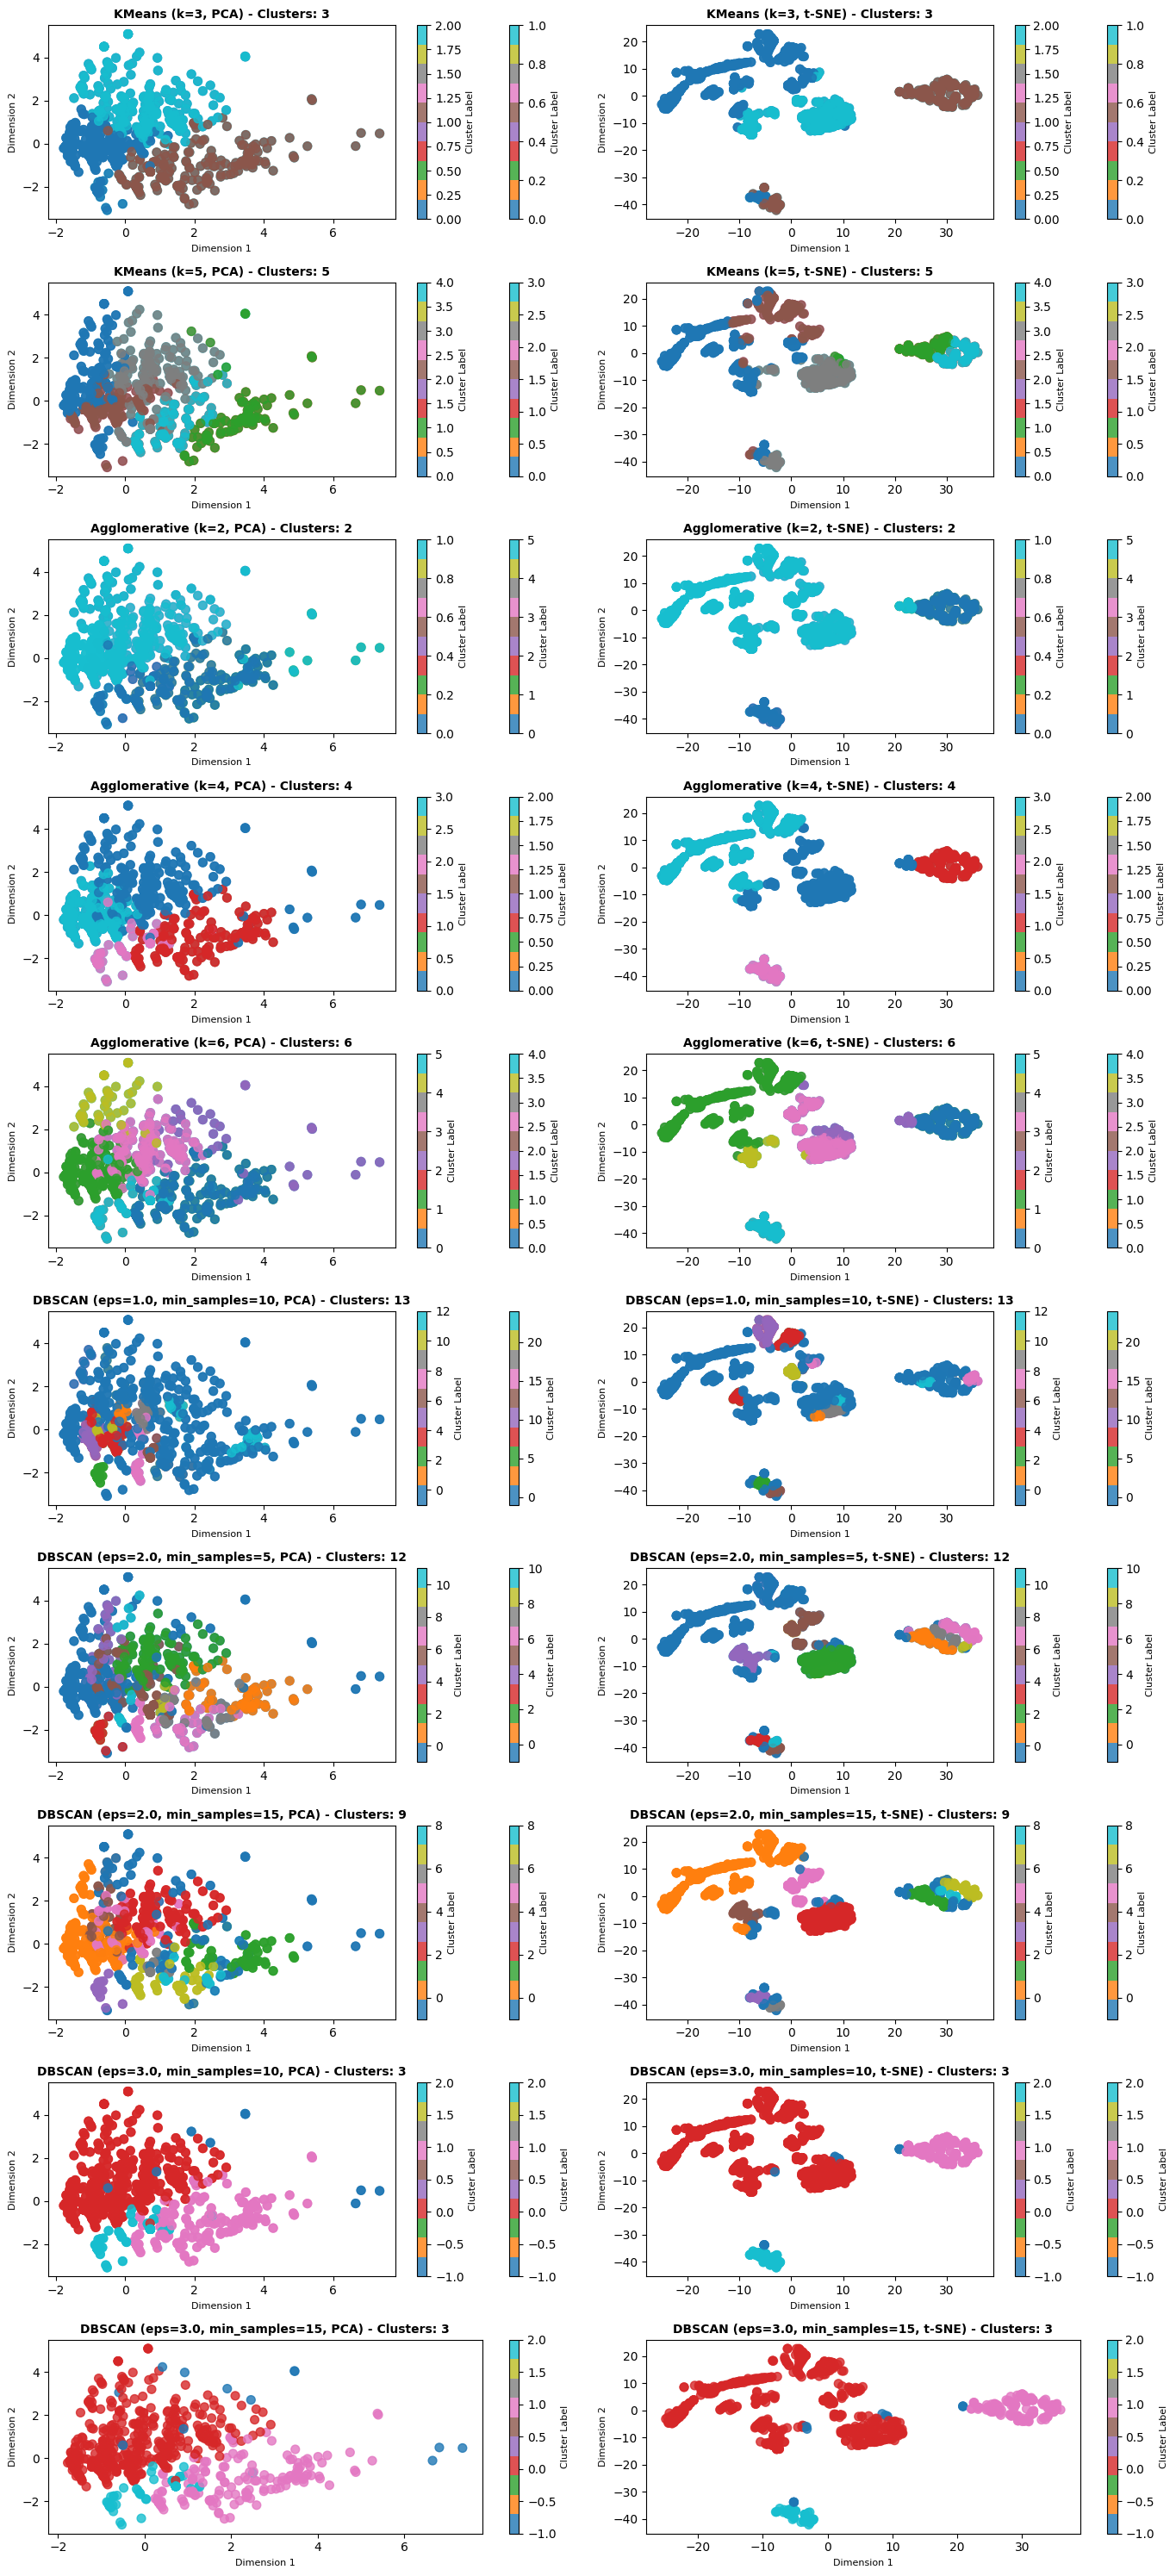

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans


def reduce_dimensions(X_scaled):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)

    return X_pca, X_tsne


def get_cluster_labels(method, X_scaled, params):
    if method == "KMeans":
        model = KMeans(n_clusters=params["n_clusters"], random_state=42)
    elif method == "Agglomerative":
        model = AgglomerativeClustering(n_clusters=params["n_clusters"])
    elif method == "DBSCAN":
        model = DBSCAN(eps=params["eps"], min_samples=params["min_samples"])
    else:
        raise ValueError(f"Unknown method: {method}")

    cluster_labels = model.fit_predict(X_scaled)

    if method == "DBSCAN":
        unique_labels = np.unique(cluster_labels)
        n_clusters = len(unique_labels[unique_labels >= 0])
    else:
        n_clusters = params["n_clusters"]

    return cluster_labels, n_clusters


def render_plot(ax, X_pca, X_tsne, cluster_labels, method, params, n_clusters=None):
    titles = [
        f"{method} ({params}, PCA)",
        f"{method} ({params}, t-SNE)"
    ]

    data = [X_pca, X_tsne]

    for i, title in enumerate(titles):
        scatter = ax[i].scatter(data[i][:, 0], data[i][:, 1], c=cluster_labels, cmap="tab10", alpha=0.8, s=50)
        ax[i].set_title(title + (f" - Clusters: {n_clusters}" if n_clusters else ""), fontsize=10, fontweight="bold")
        ax[i].set_xlabel("Dimension 1", fontsize=8)
        ax[i].set_ylabel("Dimension 2", fontsize=8)
        colorbar = plt.colorbar(scatter, ax=ax[i])
        colorbar.set_label("Cluster Label", fontsize=8)


def visualize_all_methods(X_scaled):
    X_pca, X_tsne = reduce_dimensions(X_scaled)

    total_plots = 20
    rows = total_plots // 2
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(14, 30))
    axes = axes.reshape(rows, cols)
    kmeans_params = {"n_clusters": range(2, 7)}
    for i, k in enumerate(kmeans_params["n_clusters"]):
        cluster_labels, n_clusters = get_cluster_labels("KMeans", X_scaled, {"n_clusters": k})
        row, col = divmod(i, cols)
        render_plot(axes[row, :], X_pca, X_tsne, cluster_labels, "KMeans", f"k={k}", n_clusters=n_clusters)

    agglomerative_params = {"n_clusters": range(2, 7)}
    for i, k in enumerate(agglomerative_params["n_clusters"], start=5):
        cluster_labels, n_clusters = get_cluster_labels("Agglomerative", X_scaled, {"n_clusters": k})
        row, col = divmod(i, cols)
        render_plot(axes[row, :], X_pca, X_tsne, cluster_labels, "Agglomerative", f"k={k}", n_clusters=n_clusters)

    eps_values = [1.0, 2.0, 3.0]
    min_samples_values = [5, 10, 15]
    dbscan_combinations = [(eps, min_samples) for eps in eps_values for min_samples in min_samples_values]

    for i, (eps, min_samples) in enumerate(dbscan_combinations, start=10):
        cluster_labels, n_clusters = get_cluster_labels(
            "DBSCAN", X_scaled, {"eps": eps, "min_samples": min_samples}
        )
        row, col = divmod(i, cols)
        render_plot(
            axes[row, :], X_pca, X_tsne, cluster_labels, "DBSCAN", f"eps={eps}, min_samples={min_samples}", n_clusters=n_clusters
        )

    plt.tight_layout()
    plt.show()

visualize_all_methods(X_scaled)

